# Preparing notebook

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['PYTHONHASHSEED'] = '2'

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.io import loadmat
from PIL import Image

import keras
from keras.models import load_model

from F6_func_file import *

/usr/lib/python3.11/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.1 when it was built against 1.14.0, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


## Load files

### DAMN model

In [3]:
#Load the upsampling model
upsampling_model = load_model("Upsampling_model.h5", 
                              custom_objects={"Custom_mse_conv_func": Custom_mse_conv_func, "Custom_mae_conv_func": Custom_mae_conv_func})

### Data files

In [4]:
#Load the sequence of 500 SMLM images, the reference localization image, and the DeepSTORM reconstruction
frames = Load_sequence()
hd_image = np.array(Image.open("SOSplugin_hd_image.png"))
ds_image = loadmat("Recovery_RealMicrotubules.mat")["Recovery"]

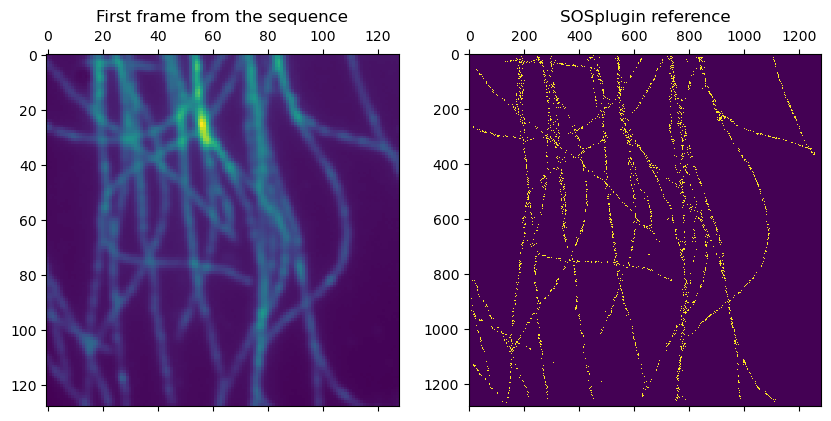

In [5]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.matshow(frames.sum(axis=0), fignum=False)
plt.title("First frame from the sequence")

plt.subplot(122)
plt.matshow(hd_image, fignum=False)
plt.title("SOSplugin reference")

plt.show()

## Evaluating

In [6]:
#Set batches to 5 or 1 to reduce memory requirements
predicted, norms = Reconstruct_data_with_model(frames, upsampling_model, batches=10, verbose=0)

reconstructed = np.mean(predicted * norms[:,None,None], axis=0)

### Visualize the full image

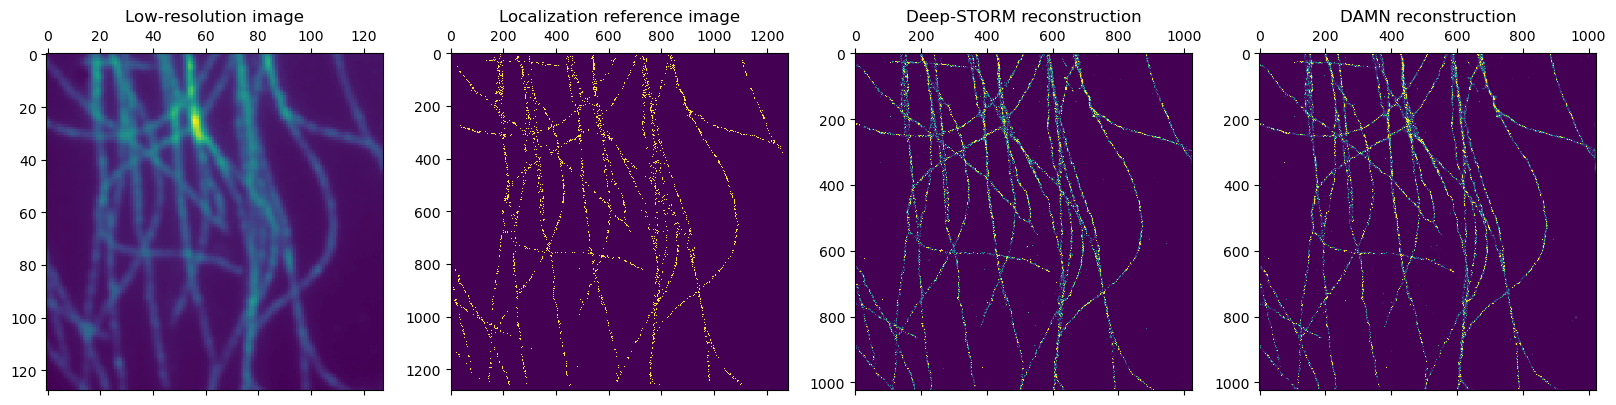

In [7]:
plt.figure(figsize=(20,5))
plt.subplot(141)
plt.matshow(frames.sum(axis=0), cmap="viridis", fignum=False)
plt.title("Low-resolution image")

plt.subplot(142)
plt.matshow(hd_image, cmap="viridis", fignum=False)
plt.title("Localization reference image")

plt.subplot(143)
plt.matshow(ds_image, cmap="viridis", fignum=False, vmin=ds_image.min(), vmax=25*ds_image.mean())
plt.title("Deep-STORM reconstruction")

plt.subplot(144)
plt.matshow(reconstructed, cmap="viridis", fignum=False, vmin=reconstructed.min(), vmax=25*reconstructed.mean())
plt.title("DAMN reconstruction")

plt.show()

### Visualize the cutout

In [8]:
a1 = 20          #Position to vertically start at (in the 128x128 field)
a2 = a1 + 30     #Position to vertically end at (in the 128x128 field)

b1 = 20          #Position to horizontally start at (in the 128x128 field)
b2 = b1 + 30     #Position to horizontally end at (in the 128x128 field)

In [9]:
#Calculating the corresponding positions in the LOC reference image and the DAMN reconstruction
frame_cutout = frames[:,a1:a2,b1:b2].sum(axis=0)
hd_image_cutout = hd_image[10*a1:10*a2, 10*b1:10*b2]
reconstructed_cutout = reconstructed[8*a1:8*a2, 8*b1:8*b2]
ds_image_cutout = ds_image[8*a1:8*a2, 8*b1:8*b2]

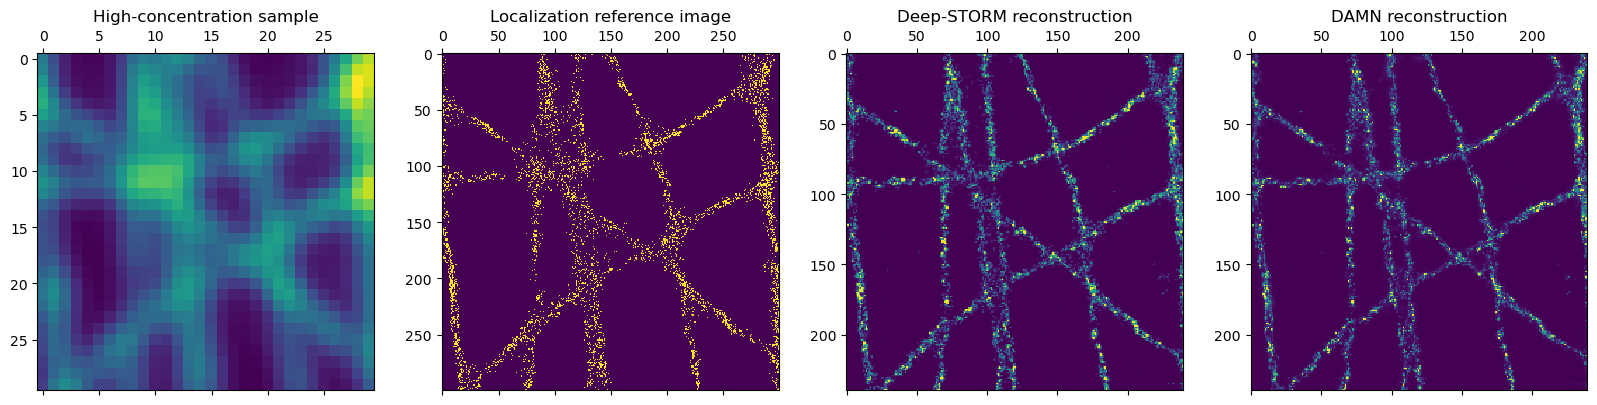

In [10]:
plt.figure(figsize=(20,5))
plt.subplot(141)
plt.matshow(frame_cutout, cmap="viridis", fignum=False)
plt.title("High-concentration sample")

plt.subplot(142)
plt.matshow(hd_image_cutout, cmap="viridis", fignum=False)
plt.title("Localization reference image")

plt.subplot(143)
plt.matshow(ds_image_cutout, cmap="viridis", fignum=False, vmin=ds_image.min(), vmax=0.35*ds_image_cutout.max())
plt.title("Deep-STORM reconstruction")

plt.subplot(144)
plt.matshow(reconstructed_cutout, cmap="viridis", fignum=False, vmin=reconstructed_cutout.min(), vmax=0.35*reconstructed_cutout.max())
plt.title("DAMN reconstruction")

plt.show()

### Microtubule profile projection

In [11]:
#Transform the image to vertically oriented microtubules and select its projection region
cut_top = 105
cut_bottom = 135
cut_left = 75
cut_right = 105

corrected_ds_image_cutout, corrected_reconstructed_cutout = Apply_correction(ds_image_cutout, reconstructed_cutout)

Text(0.5, 1.0, 'DAMN reconstruction')

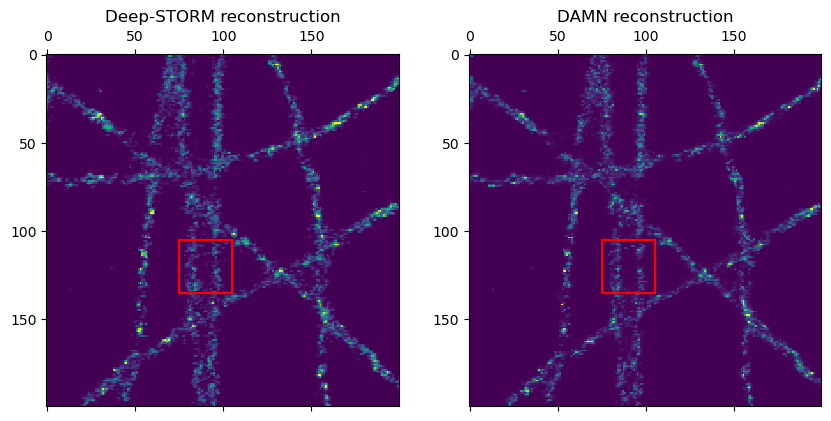

In [12]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.matshow(corrected_ds_image_cutout, cmap="viridis", fignum=False, vmin=ds_image.min(), vmax=0.5*ds_image_cutout.max())
plt.plot((cut_left, cut_right), (cut_top, cut_top), 'r-')
plt.plot((cut_left, cut_right), (cut_bottom, cut_bottom), 'r-')
plt.plot((cut_left, cut_left), (cut_top, cut_bottom), 'r-')
plt.plot((cut_right, cut_right), (cut_top, cut_bottom), 'r-')
plt.title("Deep-STORM reconstruction")

plt.subplot(122)
plt.matshow(corrected_reconstructed_cutout, cmap="viridis", fignum=False, vmin=reconstructed_cutout.min(), vmax=0.5*reconstructed_cutout.max())
plt.plot((cut_left, cut_right), (cut_top, cut_top), 'r-')
plt.plot((cut_left, cut_right), (cut_bottom, cut_bottom), 'r-')
plt.plot((cut_left, cut_left), (cut_top, cut_bottom), 'r-')
plt.plot((cut_right, cut_right), (cut_top, cut_bottom), 'r-')
plt.title("DAMN reconstruction")

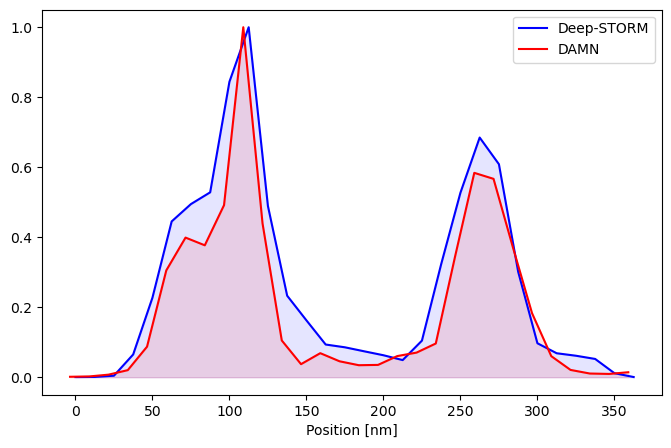

In [13]:
#Vertical projection of the restricted region
projection_ds = np.sum(corrected_ds_image_cutout[cut_top:cut_bottom,cut_left:cut_right], axis=0)
projection_damn = np.sum(corrected_reconstructed_cutout[cut_top:cut_bottom,cut_left:cut_right], axis=0)

x_axis = np.linspace(0, projection_ds.shape[0]-1, projection_ds.shape[0]) * 12.5  #12.5 nm per pixel

plt.figure(figsize=(8,5))
plt.plot(x_axis, projection_ds / projection_ds.max(), color="blue", label="Deep-STORM")
plt.fill_between(x_axis, projection_ds / projection_ds.max(), 0, color="blue", alpha=0.1)
plt.plot(x_axis-3.5, projection_damn / projection_damn.max(), color="red", label="DAMN")
plt.fill_between(x_axis-3.5, projection_damn / projection_damn.max(), 0, color="red", alpha=0.1)
plt.xlabel("Position [nm]")
plt.legend()

plt.show()